In [1]:
import pandas as pd
from os import listdir
from pathlib import Path
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt

In [2]:
root_dir = '/home/adam/cloud/gdrive/fire_project/data_091722/'
output_dir = '/home/adam/cloud/gdrive/fire_project/postfire_regen/analysis_fall_2022/'
path_to_frap = '/home/adam/cloud/gdrive/fire_project/local_data/frap_fire_perims/firep18_1.shp'
path_to_ca = '/home/adam/cloud/gdrive/fire_project/local_data/ca-state-boundary/CA_State_TIGER2016.shp'
path_to_tiles = root_dir + 'tiles/'
tiles = listdir(path_to_tiles)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

## Load regeneration data

In [4]:
li = []
for f in range(len(tiles)):
    file_path = Path(path_to_tiles + tiles[f] + '/' + tiles[f] + '_allTimeInvariantVars.feather')
    if file_path.exists():
        #print(file_path," Exists")
        tmp = pd.read_feather(file_path)
        li.append(tmp)
    else:
        print(f,"does not exist")

df = pd.concat(li, axis=0, ignore_index=True)

1 does not exist
3 does not exist
14 does not exist
16 does not exist
36 does not exist
39 does not exist
46 does not exist


In [5]:
#create list of fire years
fire_years = pd.unique(df.fireYear)

## Load frap perimeters

In [6]:
frap_raw = gpd.read_file("/home/adam/cloud/gdrive/fire_project/local_data/frap_fire_perims/firep18_1.shp")

ERROR 1: PROJ: proj_create_from_database: Open of /home/adam/miniconda3/envs/geopy/share/proj failed


In [7]:
frap_raw = frap_raw.loc[frap_raw.GIS_ACRES > 999]

## Add geometry to recovery data

In [8]:
#get crs of frap
frap_crs = frap_raw.crs

#df2 = df[['pixelID','fireYear','x','y']]

#make spatal object from pixel x y
pixel_geom = gpd.points_from_xy(df.x, df.y, z=None, crs="EPSG:3310")

#convert pixel xy to frap_crs
pixel_geom_frap_crs = pixel_geom.to_crs(frap_crs)

#create geodataframe
gdf = gpd.GeoDataFrame(
    df, geometry=pixel_geom_frap_crs)

## Spatial join fire perimeters with pixel locations

### Prep frap data

In [9]:
#add a numeric "YEAR" col to frap
YEAR = np.array(frap_raw.YEAR_)
frap_raw['YEAR'] = pd.to_numeric(YEAR, errors='coerce')
frap_raw['firePerim'] = frap_raw.geometry

### Spatial join to add the frap fire name and GIS acres

In [10]:
#spatial join one fire year at a time
gdf2 = pd.DataFrame()

for y in fire_years:
    
    frap = frap_raw.loc[frap_raw.YEAR == y][['OBJECTID','FIRE_NAME','GIS_ACRES','ALARM_DATE','CONT_DATE','CAUSE','firePerim','geometry']]
    tmp = gdf.loc[gdf.fireYear == y].sjoin(frap, how="left")
    gdf2 = pd.concat([gdf2,tmp])

### Remove duplicates with multiple fires assigned to one pixel

In [11]:
#this happened where there were two fires perims in the same year at the same place
#or where a pixel straddled two fire perimiters
#I keep the larger of the two fires in this case
gdf3 = gdf2.sort_values(["pixelID","GIS_ACRES"]).drop_duplicates(subset='pixelID', keep="last")

#save pixel geometry
gdf3['pixel_geom'] = gdf3.geometry
gdf3 = gdf3.set_geometry("pixel_geom")

### Count sample size per fire

In [12]:
gdf3['n_per_fire'] = 1
n_per_fire_df = gdf3.groupby(['FIRE_NAME'])['n_per_fire'].sum()
print(n_per_fire_df.sort_values(ascending = False).reset_index())

                  FIRE_NAME  n_per_fire
0                    MEGRAM       81244
1                   STORRIE       23392
2                      FORK       21836
3                   MCNALLY       18473
4                      BLUE       12539
5                     BUCKS       11565
6                     POWER       11404
7                      STAR       11181
8               FORT/COPPER        9475
9                   BISCUIT        9243
10                    DEAFY        8558
11                 SPECIMEN        8097
12                 FOUNTAIN        7621
13                   LARSON        7389
14                 SHEEP #1        6762
15               KING TITUS        6615
16                   YELLOW        6371
17                    DARBY        6232
18                CLEVELAND        5959
19                    FREDS        5782
20                  JACK #1        5551
21                  SPANISH        5543
22                 TEN BALD        5267
23                   TROUGH        5024


## Visualize spatial variation in RRI for a fire

In [13]:
#gdf3[gdf3.FIRE_NAME == "KING TITUS"].explore(column = "RRI_end",legend = True, vmin = 0, vmax = 1)

## See map of all fires

### Create gdf of unique fires in the study

In [14]:
fires_in_study = gdf3[['OBJECTID','FIRE_NAME','GIS_ACRES','ALARM_DATE','CONT_DATE','CAUSE','fireYear','firePerim']]\
.drop_duplicates(subset='OBJECTID').set_geometry('firePerim')
print("There are",len(fires_in_study),"fires in the study")

There are 163 fires in the study


### Plot the fires used in the study

<AxesSubplot: >

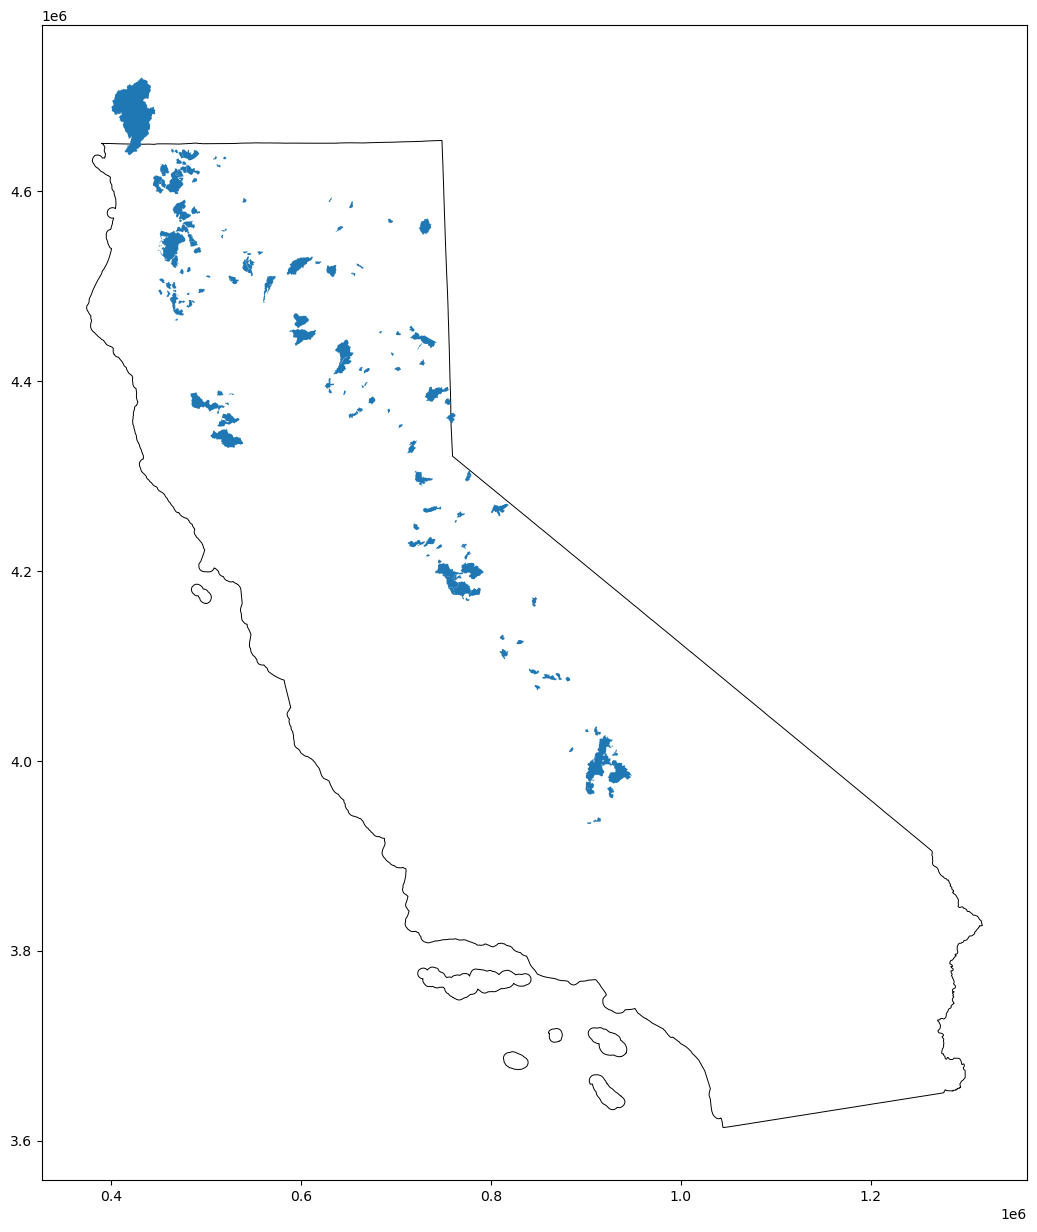

In [15]:
#Import CA
ca = gpd.read_file(path_to_ca).to_crs(frap_crs)

fig, ax = plt.subplots(figsize=(15, 15))
ca.plot(ax = ax, facecolor="none", edgecolor='black', lw=0.7)
fires_in_study.plot(ax = ax)

## Export

In [ ]:
import fiona
fiona.supported_drivers['KML'] = 'rw'

In [40]:
#Export fire perimiters
#fires_in_study.to_file(output_dir + "fire_perims_in_study_102722.shp")

#Export RRI as a shapefile
pixel_geom2 = gpd.points_from_xy(gdf3.x, gdf3.y, z=None, crs="EPSG:3310")
gdf3['pixel_geom3310'] = pixel_geom2
gdf4 = gdf3.set_geometry('pixel_geom3310')
gdf4[gdf4.FIRE_NAME == "MCNALLY"][['RRI_end','pixel_geom3310']].to_file("McNally.kml", driver="KML")

#Export regeneration data
#df3 = pd.DataFrame(gdf3)
#df3.drop(["firePerim","pixel_geom","n_per_fire","geometry"], axis = 1).to_csv(output_dir + "analysisData_102722.csv")

#Export n per fire
#n_per_fire_df.to_csv(output_dir + "n_per_fire.csv")